In [1]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
sns.set()

In [29]:
# Get Spotipy credentials from config
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [44]:
# Initialize Spotify API token
token = util.prompt_for_user_token(user_config['username'], scope='playlist-read-private', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
sp = spotipy.Spotify(auth=token)

In [45]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [46]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [47]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])


In [48]:
df = get_features_for_playlist(df, user_config['username'], 'spotify:playlist:3VZCYCHOtahASqlkxE8vJx')
df


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Way With Words,Bahamas,spotify:track:6ioeN8jQ8Qc3tS8dhpoAVi,0.35900,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729,twenty
1,Caroline,Briston Maroney,spotify:track:3S5mohVxC0Xuj0tgZ7vU7g,0.72600,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406,twenty
2,Hear Me Calling,Juice WRLD,spotify:track:13ZyrkCDmRz5xY3seuAWYk,0.30800,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499,twenty
3,94 Bentley,SAINt JHN,spotify:track:0xxbDtdmc88FOV7YvpEtft,0.07920,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217,twenty
4,I Feel Like I'm Drowning,Two Feet,spotify:track:5h0ODSutX73Vt4vZsmmph0,0.70500,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235,twenty
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,Telepathy,Jai Wolf,spotify:track:6wHU6eEdsYfw8HS5Ybg9DJ,0.00123,0.476,0.871,0.747000,0.2860,-3.996,0.0345,90.002,0.104,twenty
364,WONDER (reimagined by Smallpools),morgxn,spotify:track:3E70eL43g6tQlck8eU2qVc,0.21700,0.531,0.685,0.000570,0.0926,-5.990,0.0425,99.996,0.469,twenty
365,LăVĭNDŭR,KAMAUU,spotify:track:5TfndFjdJY502LOhS4S9wX,0.49400,0.472,0.533,0.000000,0.1470,-7.033,0.0320,142.104,0.348,twenty
366,Earth,Lil Dicky,spotify:track:2S1LebN6AXXQqJolBxlWgO,0.63900,0.694,0.664,0.000000,0.0929,-4.649,0.0500,95.941,0.676,twenty


In [49]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729
1,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406
2,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499
3,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217
4,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235


In [9]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [10]:
pca = PCA()
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.28113396, 0.16160371, 0.13046288, 0.10990763, 0.10020673,
       0.0857188 , 0.06540413, 0.0448361 , 0.02072606])

Text(0, 0.5, 'Cumulative Explained Variance')

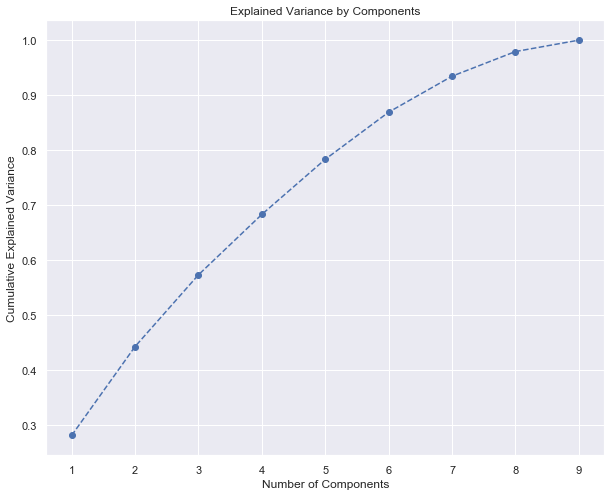

In [12]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [13]:
pca = PCA(n_components=6)
pca.fit(X_std)
scores_pca = pca.transform(X_std)
scores_pca

array([[-0.96306731, -1.35610916,  0.83181142,  0.15042731, -0.79909651,
        -1.34274821],
       [ 1.24578992,  0.05715401,  0.25547938,  0.89164362, -0.13628576,
        -1.34491174],
       [-1.44742342, -1.12782138, -0.57578295, -0.56760675,  0.21505708,
         0.43966459],
       ...,
       [ 0.20920731,  0.70552015, -0.37947406,  0.54184519,  0.01867343,
        -1.04250031],
       [-0.90035165, -1.39533303, -0.22912138, -0.99058562, -0.2314623 ,
        -0.74639488],
       [-0.53440371,  0.13428019, -1.01407417, -0.27624361, -0.26639119,
        -0.03106706]])

In [14]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

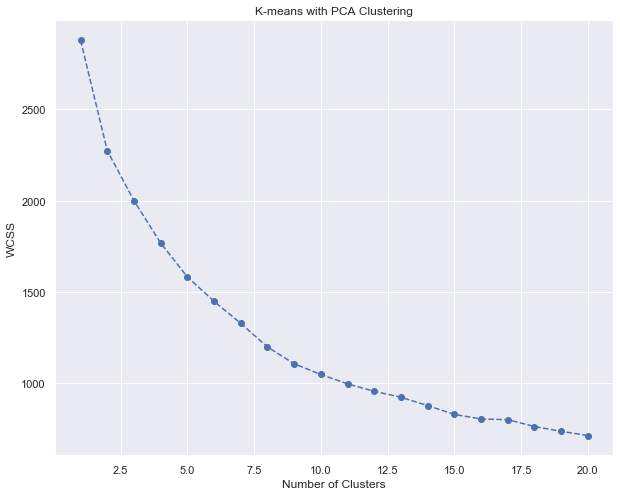

In [15]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [20]:
n_clusters = 8
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [21]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[-6:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6']
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729,-0.963067,-1.356109,0.831811,0.150427,-0.799097,-1.342748,3
1,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406,1.245790,0.057154,0.255479,0.891644,-0.136286,-1.344912,7
2,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499,-1.447423,-1.127821,-0.575783,-0.567607,0.215057,0.439665,4
3,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217,-0.791306,-0.033096,-0.887035,-0.158870,0.132705,0.251652,1
4,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235,0.224735,-0.926634,-0.911224,-0.192407,-0.170165,-0.307917,3


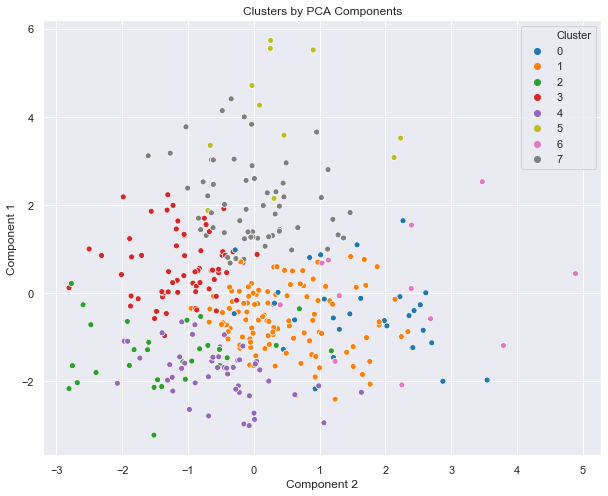

In [22]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:gray'])
plt.title('Clusters by PCA Components')
plt.show()

In [23]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']

In [24]:
preview = df.loc[df['Cluster'] == 0]
print(len(preview))
preview.head(n=50)

29


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
5,Looking Too Closely,Fink,spotify:track:7bhI6rnvaVw8qgZPn32qE0,0.328000,0.477,0.519,0.748,0.0949,-12.461,0.0358,175.094,0.1020,twenty,0
33,Yellow Ferrari,The Toxic Avenger,spotify:track:60VNy4PpJvBZxL3fztmU3t,0.001380,0.248,0.686,0.490,0.1590,-7.831,0.0436,84.981,0.3300,twenty,0
45,Bugs,Lonesome Rhodes,spotify:track:4hqzAvAbP5ulItbPPdnfuj,0.143000,0.636,0.486,0.530,0.1140,-10.267,0.0304,127.000,0.2130,twenty,0
64,More I See,S. Carey,spotify:track:58iT2lT6yiTwJyN8zlXrKt,0.224000,0.473,0.460,0.403,0.0802,-10.936,0.0263,141.011,0.4280,twenty,0
92,Drive,Milo Greene,spotify:track:03U7jeIiYP2kZX1YCHCniw,0.182000,0.486,0.891,0.563,0.1400,-10.037,0.0486,169.969,0.2390,twenty,0
98,La Luh,Choomba,spotify:track:5SrjVeWdiF6YBVLINrwAqU,0.105000,0.680,0.879,0.544,0.1590,-5.542,0.0347,127.987,0.3000,twenty,0
101,Soft Stud,Black Belt Eagle Scout,spotify:track:2i1jIsRpjjzaV85v1fS4Hu,0.003890,0.550,0.728,0.431,0.1170,-7.091,0.0274,124.095,0.3350,twenty,0
102,You Can Have It All,Yo La Tengo,spotify:track:4GrfClvQgCVLsCfqw7YthQ,0.637000,0.515,0.833,0.944,0.3020,-9.409,0.0362,178.471,0.9650,twenty,0
104,Never Going Home,Hazel English,spotify:track:4iq4RFWmQc3zFgBgyrpahF,0.071300,0.416,0.779,0.730,0.0658,-5.647,0.0308,161.890,0.2960,twenty,0
109,Toi Et Moi,Paradis,spotify:track:3AVyKOmMgvRjsC576xWw78,0.004120,0.703,0.760,0.761,0.1110,-7.308,0.0635,113.010,0.6080,twenty,0


In [25]:
for i in range(1, n_clusters+1):
    result = sp.user_playlist_create(user_config['username'], 'cluster'+str(i), public=True, collaborative=False, description='')
    playlist_id = result['id']
    songs = list(df.loc[df['Cluster'] == i - 1]['track_URI'])
    if len(songs) > 100:
        sp.playlist_add_items(playlist_id, songs[:100])
        sp.playlist_add_items(playlist_id, songs[100:])
    else:
        sp.playlist_add_items(playlist_id, songs)


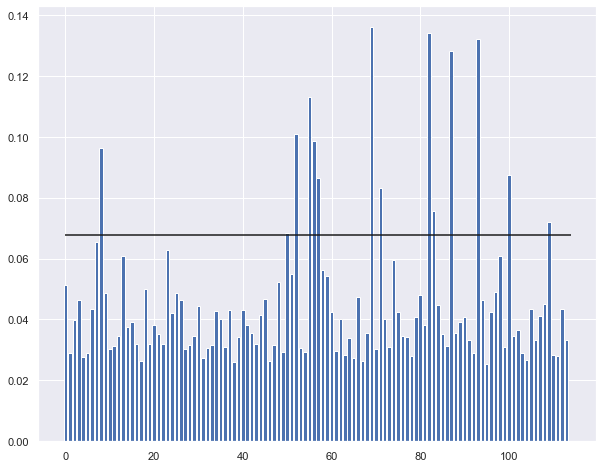

In [105]:
plt.figure(figsize=(10,8))
test_cluster = df.loc[df['Cluster'] == 2]
y = test_cluster['speechiness']
x = [i for i in range(len(y))]
plt.bar(x, y)
plt.hlines(np.mean(df['speechiness']), 0, len(y))